# Golden spiral test

This is a comparison of the direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will use a set of points on the sphere laid out as a golden spiral (a.k.a. a Fibonacci spiral) as an example and impose a "survey footprint" that $|\cos\theta|<1/2$.

In [1]:
import numpy  as np
import healpy as hp
import sys
#
import matplotlib.pyplot as plt
#
sys.path.append('../sht')
from sht import DirectSHT

In [2]:
rng = np.random.default_rng()

In [3]:
# Set up an sht instance.  We will set Nx to be "large",
# so that we are confident in our interpolation.
Nl   = 1500
Nx   = 2*Nl+1
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)

In [4]:
# Set up a "binning matrix" that combines adjacent
# ells into coarser bins.
bins = np.zeros( (Nl,Nl) )
ii   = 0
l0,l1= 2,16 # Remove monopole and dipole.
while l1<=Nl:
    bins[ii,l0:min(l1,Nl)] = 1/float(l1-l0)
    dell  = int(np.ceil(np.sqrt(4*l1)+8.))
    l0,l1 = l1,l1+dell
    ii   += 1
bins = bins[:ii,:]

In [5]:
# Code to lay down N points in a golden spiral (a.k.a. Fibonacci spiral).
def golden_spiral(Npnt,cosmax=0.5,eps=1.25e-3):
    """Returns (theta,phi,wt) for Npnt points in a golden spiral
    and randomly perturbed by eps."""
    grat  = 0.5*(1 + np.sqrt(5.)) # Golden ratio.
    kk    = np.arange(Npnt,dtype='float64')
    cost  = cosmax*(1-(2*kk+1)/Npnt)
    phi   = 2*np.pi*( (kk/grat)%1 )
    cost += rng.normal(loc=0,scale=eps,size=Npnt)
    phi  += rng.normal(loc=0,scale=eps,size=Npnt)
    theta = np.arccos(np.clip(cost,-cosmax,cosmax))
    wt    = np.ones(Npnt)
    return( (theta,phi,wt) )

In [6]:
# Generate points and cut to the "observed region".
npnt = 2**20    # About 1 million points.
npnt = 5*2**15  # 163840 points.
thetas,phis,wts = golden_spiral(npnt)

## Harmonic analysis.

Let's compute the $a_{\ell m}$ by direct summation, then compute the binned, pseudo-power spectrum and finally look at the sources on a map.

In a notebook this is kind of slow, but not unmanageable (around a minute).

In [7]:
halm = sht(thetas,phis,wts)
hcl  = hp.alm2cl(halm)
# Bin them up.
ell = np.dot(bins,np.arange(Nl))
hcl = np.dot(bins,hcl)

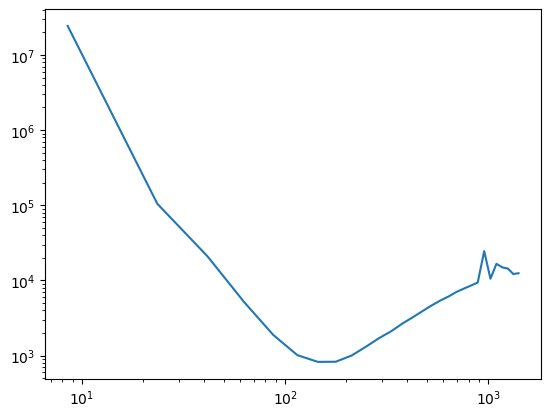

In [8]:
# Let's just plot the angular power spectrum so we know what we've got.
plt.loglog(ell,hcl)

0.0 180.0 -180.0 180.0


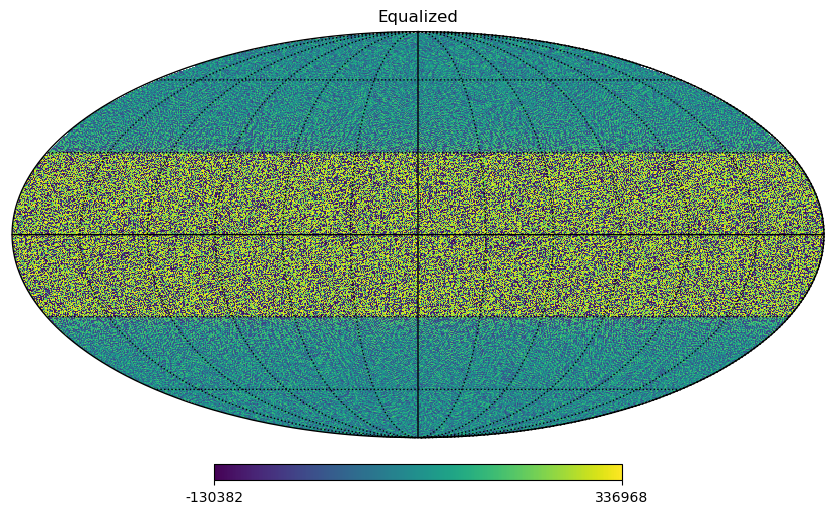

In [9]:
nside = 256
#
hp.mollview(hp.alm2map(halm,nside),norm='hist',title='Equalized')
hp.graticule()
plt.show()

## Pixel-based analysis

Now let's look at the same point set by first binning them on a map and then analyzing them using the "standard" healpy routines.

In [10]:
def make_map(thetas,phis,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = 12*nside**2
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

0.0 180.0 -180.0 180.0


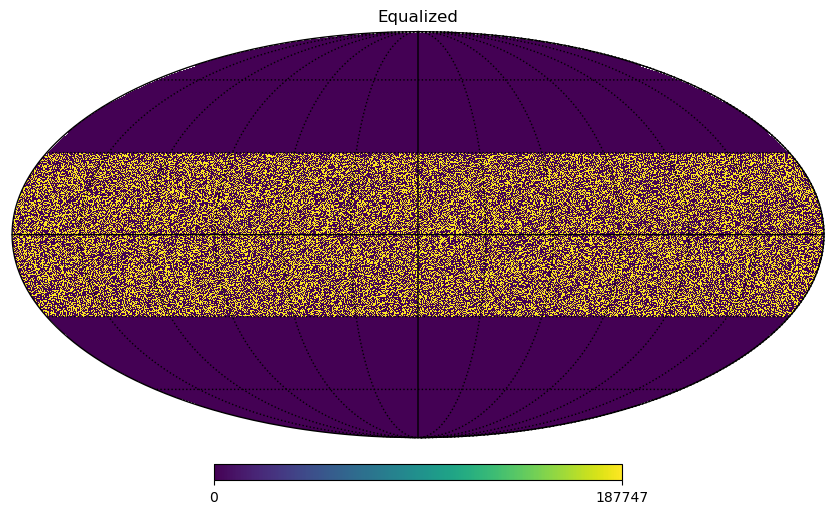

In [11]:
# Show an example at some nside.
dmap = make_map(thetas,phis,256)
hp.mollview(dmap,norm='hist',title='Equalized')
hp.graticule()
plt.show()

Now compare the power spectra as a function of the map Nside.

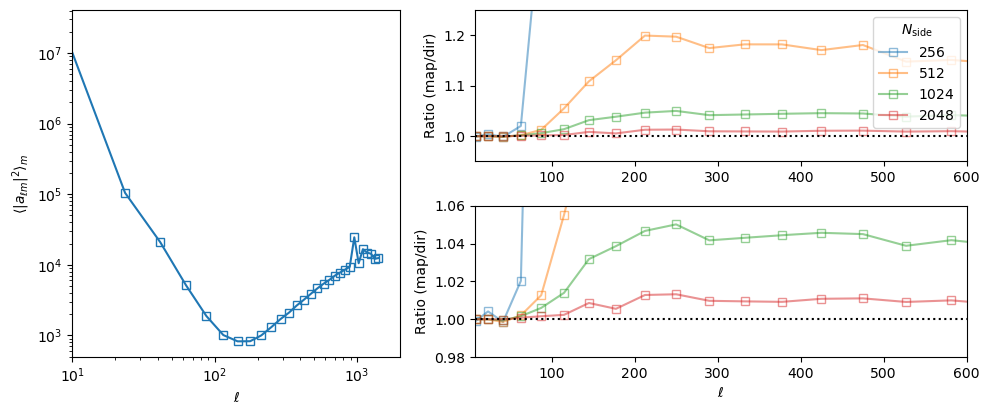

In [12]:
#fig,ax = plt.subplots(2,2,sharex=True,sharey=False,figsize=(8,6))
fig = plt.figure(figsize=(10,4.25))
gs  = fig.add_gridspec(2,2,width_ratios=[2,3])
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])
#
ax0.loglog(ell,hcl,'s-',mfc='None')
ax0.set_xlim(10,1999.)
ax0.set_xlabel(r'$\ell$')
ax0.set_ylabel(r'$\langle |a_{\ell m}|^2\rangle_m$')
#
icol= 0
for nside in [256,512,1024,2048]:
    dmap = make_map(thetas,phis,nside)
    mcl  = hp.sphtfunc.anafast(dmap,alm=False,\
                               lmax=sht.Nell-1,pol=False)
    ratio= np.dot(bins,mcl)/hcl
    #
    ax1.plot(ell,ratio,'s-',color='C'+str(icol),alpha=0.5,\
             mfc='None',label='${:4d}$'.format(nside))
    ax2.plot(ell,ratio,'s-',color='C'+str(icol),alpha=0.5,\
             mfc='None')
    icol = (icol+1)%10
ax1.axhline(1.0,ls=':',color='k')
ax2.axhline(1.0,ls=':',color='k')
ax1.set_xlim(8.0,600)
ax2.set_xlim(8.0,600)
ax1.set_ylabel(r'Ratio (map/dir)')
ax2.set_ylabel(r'Ratio (map/dir)')
ax1.legend(title=r'$N_{\rm side}$',loc=1)
ax1.set_ylim(0.95,1.25)
ax1.set_yscale('linear')
ax2.set_ylim(0.98,1.06)
ax2.set_yscale('linear')
ax2.set_xlabel(r'$\ell$')
#
plt.tight_layout()
#plt.savefig('golden_spiral.pdf')

# The End